In [20]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings(action='ignore')

In [21]:
TEST_SIZE = 0.4
FIG_SIZE = (8, 8)
RANDOM_STATE = 1
CORRELATION_THRESHOLD = 0.9
COLUMN_FOR_CLASSIFICATION = 'disposition'

In [22]:
df = pd.read_csv('../data/k2pandc_2025.10.03_11.39.15.csv')
df.tail()

,rowid,pl_name,hostname,pl_letter,k2_name,epic_hostname,epic_candname,hd_name,hip_name,tic_id,...,releasedate,pl_nnotes,k2_campaigns,k2_campaigns_num,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
3999,4000,WASP-85 A b,WASP-85 A,b,K2-94 b,EPIC 201862715,EPIC 201862715.01,NaN,NaN,TIC 380619414,...,2019-09-05,1,1,1.0,0,0,0,0,0,0
4000,4001,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2022-05-23,0,17,1.0,1,0,0,0,0,0
4001,4002,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2018-09-06,0,17,1.0,1,0,0,0,0,0
4002,4003,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2023-04-17,0,17,1.0,1,0,0,0,0,0
4003,4004,Wolf 503 b,Wolf 503,b,K2-262 b,EPIC 212779563,NaN,NaN,HIP 67285,TIC 187278212,...,2025-08-28,0,17,1.0,1,0,0,0,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Columns: 295 entries, rowid to pl_ndispec
dtypes: float64(236), int64(26), object(33)
memory usage: 9.0+ MB


In [24]:
label_encoder = LabelEncoder()
df[COLUMN_FOR_CLASSIFICATION] = label_encoder.fit_transform(
    df[COLUMN_FOR_CLASSIFICATION]
)

class_names = label_encoder.classes_
for idx, cls in enumerate(class_names):
    print(idx, cls, df[df[COLUMN_FOR_CLASSIFICATION] == idx].shape[0])

0 CANDIDATE 1374
1 CONFIRMED 2315
2 FALSE POSITIVE 293
3 REFUTED 22


In [25]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(
    columns=[
        'rowid',
        'sy_mnum',
        'cb_flag',
        'pul_flag',
        'ptv_flag',
        'ast_flag',
        'obm_flag',
        'etv_flag',
        'ima_flag',
        'dkin_flag',
        'st_nspec',
        'pl_ndispec',
        'pl_controv_flag',
        'micro_flag',
        'pl_nespec',
        'tran_flag',
        'pl_ntranspec',
        'st_nrvc',
        'st_nphot',
        'ttv_flag',
        'sy_snum',
        *list(df.filter(regex='err$|lim$', axis=1).columns),
    ],
    axis=1,
)

In [26]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

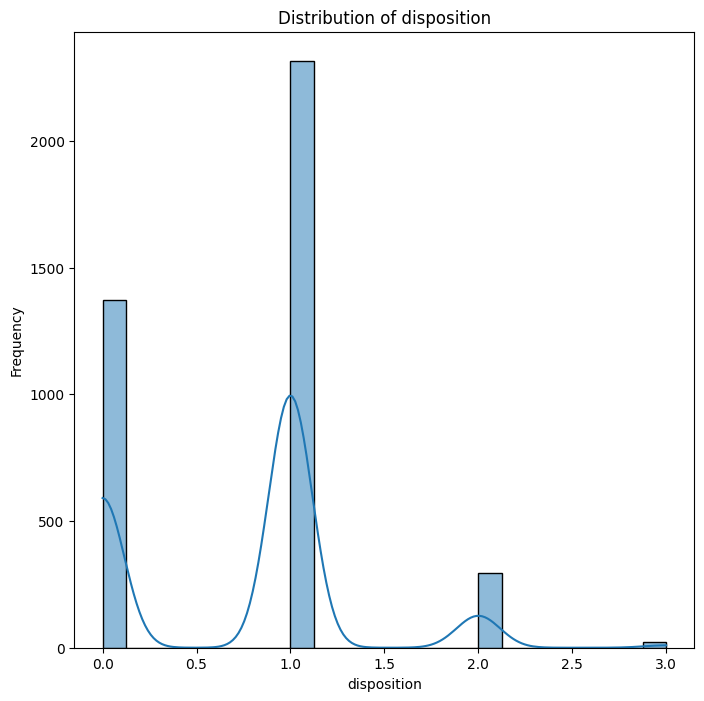

In [27]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=FIG_SIZE)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

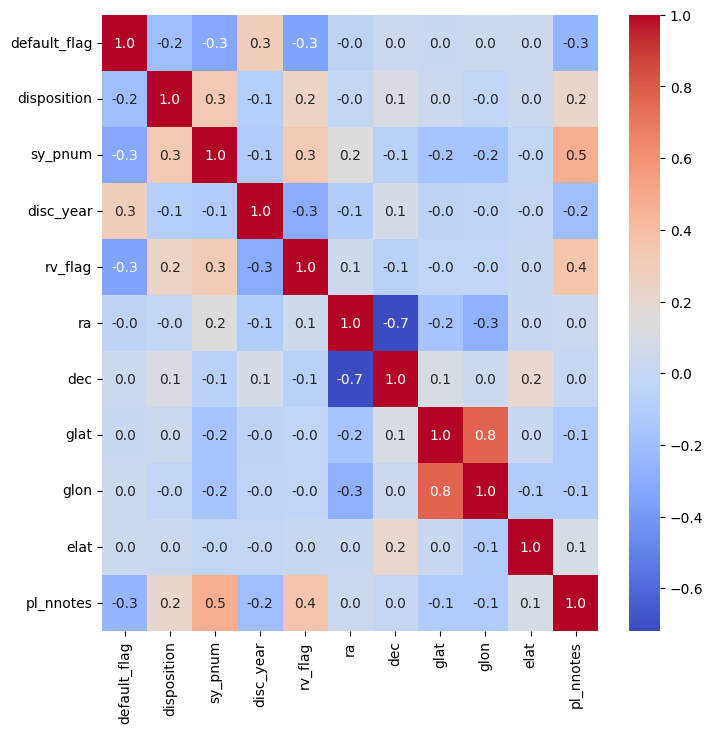

In [28]:
plt.figure(figsize=FIG_SIZE)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')

In [29]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   default_flag  4004 non-null   int64  
 1   sy_pnum       4004 non-null   int64  
 2   disc_year     4004 non-null   int64  
 3   rv_flag       4004 non-null   int64  
 4   ra            4004 non-null   float64
 5   dec           4004 non-null   float64
 6   glat          4004 non-null   float64
 7   glon          4004 non-null   float64
 8   elat          4004 non-null   float64
 9   pl_nnotes     4004 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 312.9 KB


In [31]:
X.head()

,default_flag,sy_pnum,disc_year,rv_flag,ra,dec,glat,glon,elat,pl_nnotes
0,0,1,2016,1,53.651123,20.599021,-28.05348,166.79660,1.31208,1
1,0,1,2016,1,53.651123,20.599021,-28.05348,166.79660,1.31208,1
2,1,1,2016,1,53.651123,20.599021,-28.05348,166.79660,1.31208,1
3,1,0,2018,0,183.846245,-6.268329,55.48289,286.98079,-4.22377,0
4,0,0,2018,0,183.846245,-6.268329,55.48289,286.98079,-4.22377,0


In [32]:
X.tail()

,default_flag,sy_pnum,disc_year,rv_flag,ra,dec,glat,glon,elat,pl_nnotes
3999,0,1,2016,1,175.908033,6.563784,63.87857,261.79320,4.39767,1
4000,1,1,2018,1,206.846198,-6.139337,54.08446,327.11621,4.61633,0
4001,0,1,2018,1,206.846198,-6.139337,54.08446,327.11621,4.61633,0
4002,0,1,2018,1,206.846198,-6.139337,54.08446,327.11621,4.61633,0
4003,0,1,2018,1,206.846198,-6.139337,54.08446,327.11621,4.61633,0


In [33]:
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(X)
X = pd.DataFrame(imputed_features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [34]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f'Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%')
print(f'Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%')

Training accuracy: 99.95%
Testing accuracy: 95.69%


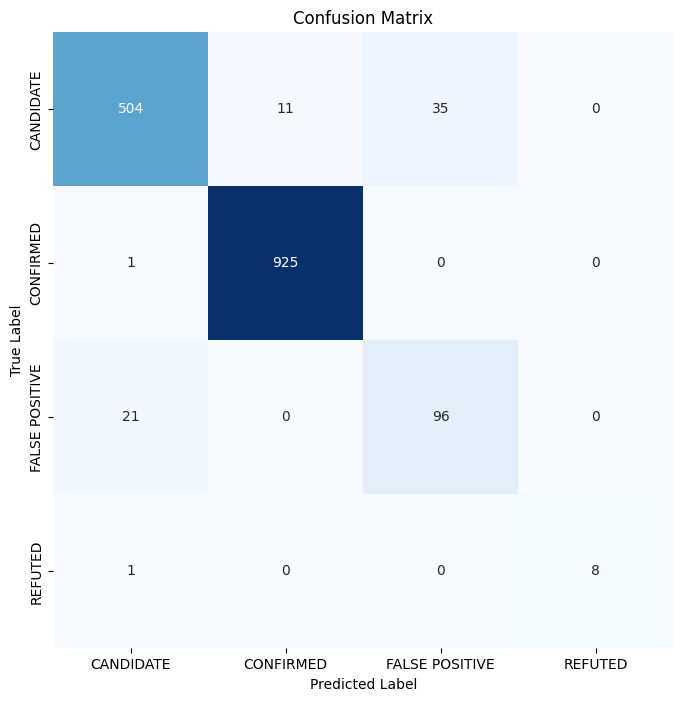

In [36]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))

plt.figure(figsize=FIG_SIZE)
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

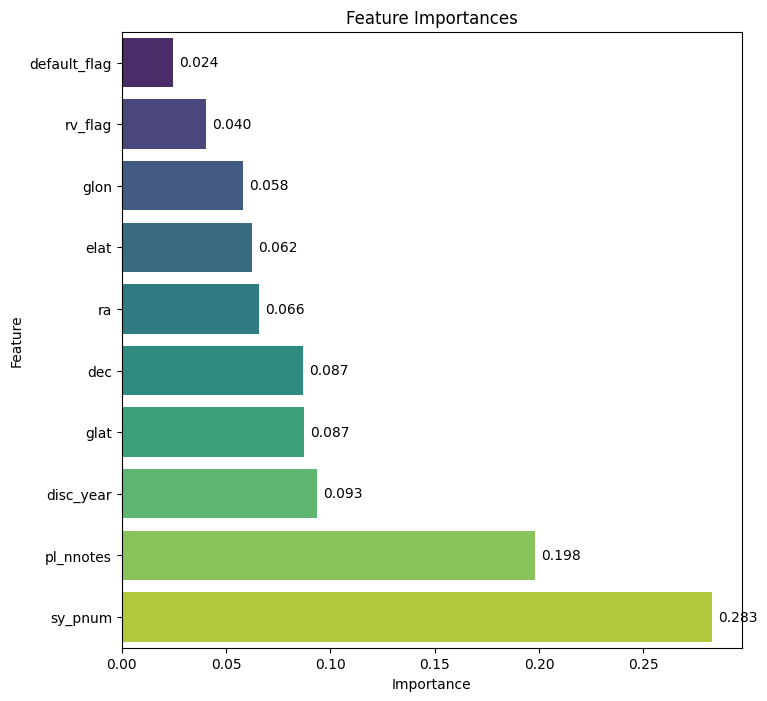

In [37]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=FIG_SIZE)
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f'{v:.3f}', va='center')

plt.show()

In [38]:
os.makedirs('./models', exist_ok=True)

joblib.dump(rf_clf, './models/rf_k2.pkl')
joblib.dump(imputer, './models/imputer_k2.pkl')
joblib.dump(scaler, './models/scaler_k2.pkl')

['./models/scaler_k2.pkl']